In [25]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import tensorflow as tf
import numpy as np
import imageio
import json
import random
import time
from run_nerf_helpers import *
from run_nerf import *
from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data, load_blender_data_with_rotation
tf.compat.v1.enable_eager_execution()


In [3]:
def config_parser():

    import configargparse
    parser = configargparse.ArgumentParser()
    parser.add_argument('--config', is_config_file=True,
                        help='config file path')
    parser.add_argument("--expname", type=str, help='experiment name')
    parser.add_argument("--basedir", type=str, default='./logs/',
                        help='where to store ckpts and logs')
    parser.add_argument("--datadir", type=str,
                        default='./data/llff/fern', help='input data directory')

    # training options
    parser.add_argument("--netdepth", type=int, default=8,
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256,
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int,
                        default=8, help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256,
                        help='channels per layer in fine network')
    parser.add_argument("--N_rand", type=int, default=32*32*4,
                        help='batch size (number of random rays per gradient step)')
    parser.add_argument("--lrate", type=float,
                        default=5e-4, help='learning rate')
    parser.add_argument("--lrate_decay", type=int, default=250,
                        help='exponential learning rate decay (in 1000s)')
    parser.add_argument("--chunk", type=int, default=1024*32,
                        help='number of rays processed in parallel, decrease if running out of memory')
    parser.add_argument("--netchunk", type=int, default=1024*64,
                        help='number of pts sent through network in parallel, decrease if running out of memory')
    parser.add_argument("--no_batching", action='store_true',
                        help='only take random rays from 1 image at a time')
    parser.add_argument("--no_reload", action='store_true',
                        help='do not reload weights from saved ckpt')
    parser.add_argument("--ft_path", type=str, default=None,
                        help='specific weights npy file to reload for coarse network')
    parser.add_argument("--random_seed", type=int, default=None,
                        help='fix random seed for repeatability')
    
    # pre-crop options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops')
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops')    

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64,
                        help='number of coarse samples per ray')
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray')
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter')
    parser.add_argument("--use_viewdirs", action='store_true',
                        help='use full 5D input instead of 3D')
    parser.add_argument("--i_embed", type=int, default=0,
                        help='set 0 for default positional encoding, -1 for none')
    parser.add_argument("--multires", type=int, default=10,
                        help='log2 of max freq for positional encoding (3D location)')
    parser.add_argument("--multires_views", type=int, default=4,
                        help='log2 of max freq for positional encoding (2D direction)')
    parser.add_argument("--raw_noise_std", type=float, default=0.,
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended')

    parser.add_argument("--render_only", action='store_true',
                        help='do not optimize, reload weights and render out render_poses path')
    parser.add_argument("--render_test", action='store_true',
                        help='render the test set instead of render_poses path')
    parser.add_argument("--render_factor", type=int, default=0,
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview')

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff',
                        help='options: llff / blender / deepvoxels')
    parser.add_argument("--testskip", type=int, default=8,
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels')

    # deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek',
                        help='options : armchair / cube / greek / vase')

    # blender flags
    parser.add_argument("--white_bkgd", action='store_true',
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.add_argument("--half_res", action='store_true',
                        help='load blender synthetic data at 400x400 instead of 800x800')

    # llff flags
    parser.add_argument("--factor", type=int, default=8,
                        help='downsample factor for LLFF images')
    parser.add_argument("--no_ndc", action='store_true',
                        help='do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.add_argument("--lindisp", action='store_true',
                        help='sampling linearly in disparity rather than depth')
    parser.add_argument("--spherify", action='store_true',
                        help='set for spherical 360 scenes')
    parser.add_argument("--llffhold", type=int, default=8,
                        help='will take every 1/N images as LLFF test set, paper uses 8')

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=100,
                        help='frequency of console printout and metric loggin')
    parser.add_argument("--i_img",     type=int, default=500,
                        help='frequency of tensorboard image logging')
    parser.add_argument("--i_weights", type=int, default=10000,
                        help='frequency of weight ckpt saving')
    parser.add_argument("--i_testset", type=int, default=50000,
                        help='frequency of testset saving')
    parser.add_argument("--i_video",   type=int, default=50000,
                        help='frequency of render_poses video saving')

    # rotation equivariant option
    parser.add_argument("--use_rotation",action='store_true',
                        help='use rotation equivariant for training')

    return parser

In [6]:
parser = config_parser()
args = parser.parse_args("--config config_lego_rotation.txt")

if args.random_seed is not None:
    print('Fixing random seed', args.random_seed)
    np.random.seed(args.random_seed)
    tf.compat.v1.set_random_seed(args.random_seed)

# lego dataset is blender type + white background

if args.dataset_type == 'blender':
    # this pose here only takes transformation matrix, not rotation
    images, poses, render_poses, hwf, i_split, rotations = load_blender_data_with_rotation(
        args.datadir, args.half_res, args.testskip)
    print('Loaded blender', images.shape,
            render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    near = 2.
    far = 6.


Loaded blender (138, 400, 400, 4) (40, 4, 4) [400, 400, 555.5555155968841] ./data/nerf_synthetic/lego


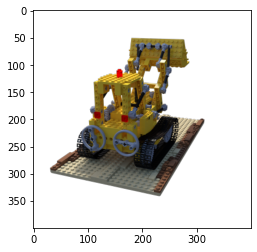

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.imshow(images[1])

In [12]:
white = images[..., :3]*images[..., -1:] + (1.-images[..., -1:])

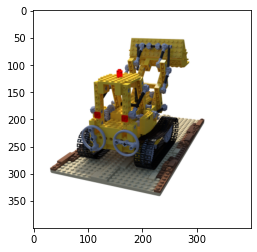

In [15]:
plt.imshow(white[1])

In [17]:
if args.white_bkgd:
    images = images[..., :3]*images[..., -1:] + (1.-images[..., -1:])
else:
    images = images[..., :3]

In [33]:
 # Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if args.render_test:
    render_poses = np.array(poses[i_test])

# Create log dir and copy the config file
basedir = args.basedir
expname = args.expname
os.makedirs(os.path.join(basedir, expname), exist_ok=True)
f = os.path.join(basedir, expname, 'args.txt')
with open(f, 'w') as file:
    for arg in sorted(vars(args)):
        attr = getattr(args, arg)
        file.write('{} = {}\n'.format(arg, attr))
if args.config is not None:
    f = os.path.join(basedir, expname, 'config.txt')
    with open(f, 'w') as file:
        file.write(open(args.config, 'r').read())

# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, models = create_nerf(
    args)

bds_dict = {
    'near': tf.cast(near, tf.float32),
    'far': tf.cast(far, tf.float32),
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

# Create optimizer
lrate = args.lrate
if args.lrate_decay > 0:
    lrate = tf.keras.optimizers.schedules.ExponentialDecay(lrate,
                                                            decay_steps=args.lrate_decay * 1000, decay_rate=0.1)
optimizer = tf.keras.optimizers.Adam(lrate)
models['optimizer'] = optimizer

global_step = tf.compat.v1.train.get_or_create_global_step()
global_step.assign(start)

# Prepare raybatch tensor if batching random rays
N_rand = args.N_rand
use_batching = not args.no_batching

N_iters = 200000
print('Begin')
print('TRAIN views are', i_train)
print('TEST views are', i_test)
print('VAL views are', i_val)

if args.use_rotation:
    print("Start experimental run with rotation equivariant")
    

# Summary writers
writer = tf.contrib.summary.create_file_writer(
    os.path.join(basedir, 'summaries', expname))
writer.set_as_default()

MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(?, 90) (?, 63) (?, 27)
Not ndc!
Found ckpts ['./logs/lego_test/model_000000.npy', './logs/lego_test/model_010000.npy', './logs/lego_test/model_020000.npy', './logs/lego_test/model_030000.npy', './logs/lego_test/model_040000.npy', './logs/lego_test/model_050000.npy', './logs/lego_test/model_060000.npy', './logs/lego_test/model_070000.npy', './logs/lego_test/model_080000.npy', './logs/lego_test/model_090000.npy', './logs/lego_test/model_100000.npy', './logs/lego_test/model_110000.npy', './logs/lego_test/model_120000.npy', './logs/lego_test/model_130000.npy', './logs/lego_test/model_140000.npy', './logs/lego_test/model_150000.npy', './logs/lego_test/model_160000.npy', './logs/lego_test/model_170000.npy', './logs/lego_test/model_180000.npy', './logs/lego_test/model_190000.npy', './logs/lego_test/model_200000.npy', './logs/lego_test/model_210000.npy', './logs/lego_test/model_22

In [52]:
img_i = np.random.choice(i_train)
target = images[img_i]
pose = poses[img_i, :3, :4] # remove last column which is always [0,0,0,1]

rays_o, rays_d = get_rays(H, W, focal, pose)
dH = int(H//2 * args.precrop_frac)
dW = int(W//2 * args.precrop_frac)
coords = tf.stack(tf.meshgrid(
    tf.range(H//2 - dH, H//2 + dH), 
    tf.range(W//2 - dW, W//2 + dW), 
    indexing='ij'), -1)
coords = tf.reshape(coords, [-1, 2])
select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)
select_inds = tf.gather_nd(coords, select_inds[:, tf.newaxis])
rays_o = tf.gather_nd(rays_o, select_inds)
rays_d = tf.gather_nd(rays_d, select_inds)
batch_rays = tf.stack([rays_o, rays_d], 0)
target_s = tf.gather_nd(target, select_inds)